# Credit Fraud detector 
## Dealing with Imbalanced Dataset
In this kernel we will explore some predictive models to see how good they are in predictiong 
whether a specific transaction is a real one or a fraud one, as shown in the dataset the features are scaled 
and the features names are not described for privacy reasons, However we can still do some 
pretty analysis on this dataset, let's get started!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

## 1- Understanding Our Data

In [3]:
DATA_PATH = Path('data/creditcard.csv')
data = pd.read_csv(DATA_PATH)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Gather Sense of Our Data:
* Remember except for the transaction and the amount we know nothing about the rest of the columns, the only thing that we know is that these columns have already been scaled

* Most of the transactions were Non_Fraud(99.83%) of the time

In [5]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

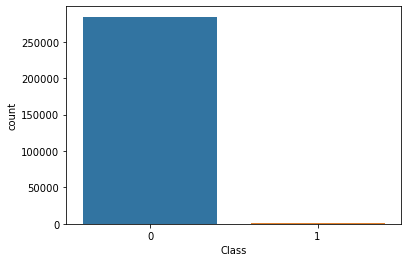

In [6]:
sns.countplot('Class', data=data)

In [7]:
print('Not a fraud', round(data['Class'].value_counts()[0] / len(data) *100, 2), '% of the dataset')
print('fraud', round(data['Class'].value_counts()[1] / len(data) *100, 2), '% of the dataset')

Not a fraud 99.83 % of the dataset
fraud 0.17 % of the dataset


- Notice how imbalanced is our original dataset, most 
  of the transactions are Non-Frauds, so if we use this dataset as the base of our predictive model, we might get a lot of errors and our algorithm will probably overfit since it will assume that the most transactions are Non-Fraud, but we don't want our model to assume we want it to notice ore predict the patternof the fraud.

- Distibutions: By seeing the distributions we can have an idea how skewed are these features


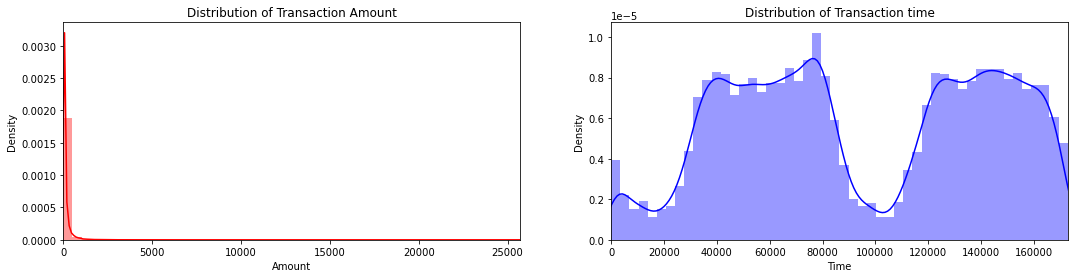

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
amount_vals = data['Amount']
time_vals = data['Time']

sns.distplot(amount_vals, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount')
ax[0].set_xlim([min(amount_vals), max(amount_vals)])

sns.distplot(time_vals, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction time')
ax[1].set_xlim([min(time_vals), max(time_vals)])

plt.show()

### Scaling and Distribution
in this phase of the kernel, we will first scale the columns, [Time, Amount].
because Time and Amount should be scaled as the other columns, in other hand we want to create a subsample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, to help our algorithms better understand patterns that determines whether a transaction is a fraud or not.
#### What is a sub-sample?
a sub-sample is a 50/50 ratio of fraud and non-fraud transactions
#### Warnings of an Imbalanced Dataset..
* __Overfitting__: our classification model will assume that in most cases the transactions are not frauds, but we want our model to be certain when a fraud occurs.

* __Wrong Correlations__: although we don't know what the "V" features stand for, it will be useful to understand how each of yhis features influence 
  the results by having an imbalanced dataframe we are not able to see the true correlations between the class and the features.
  
* there are __492 cases__ of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe.

In [15]:
# since most of the features are scaled we should also scale the Time and Amount features
from sklearn.preprocessing import StandardScaler, RobustScaler
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)

In [17]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
